# Twitter Sentiment Analysis with Logistic Regression

The dataset is divided into two categories of tweets: positive (1) and negative (0).

In the positive tweets we find feelings of *happiness*, *excitement*, *gratitude*, in the negative tweets we find feelings of *sadness*, *depression*, anger.

The goal is to train a model that can classify the general sentiment of the tweet.

In [ ]:
# importing module
import nltk
nltk.download("popular") #importing dataset
from nltk.corpus import twitter_samples
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt


positive_sample = twitter_samples.strings('positive_tweets.json')
negative_sample = twitter_samples.strings('negative_tweets.json')

Making Pandas DataFrame

In [28]:
d = {"tweet":positive_sample+negative_sample,"sentiment":[1]*5000+[0]*5000}
df = pd.DataFrame(data=d)
df

,tweet,sentiment
0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,1
1,@Lamb2ja Hey James! How odd :/ Please call our...,1
2,@DespiteOfficial we had a listen last night :)...,1
3,@97sides CONGRATS :),1
4,yeaaaah yippppy!!! my accnt verified rqst has...,1
...,...,...
9995,I wanna change my avi but uSanele :(,0
9996,MY PUPPY BROKE HER FOOT :(,0
9997,where's all the jaebum baby pictures :((,0
9998,But but Mr Ahmad Maslan cooks too :( https://t...,0


### Data Cleaning

Tweets include special characters (like hashtags '#') or links (https://.....) that are useless for reaching our goal.

The Data Cleaning phase helps to remove all these less important characters ("#today" => "today") and to remove some words that do not add meaning to the sentence (the "stopwords").

In [29]:
import re                                  
import string
from nltk.corpus import stopwords          
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer        

def text_process(tweet):
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'@[\w]+', '', tweet)
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    tokenizer = TweetTokenizer()
    tweet_tokenized = tokenizer.tokenize(tweet)
    stopwords_english = stopwords.words('english')
    stemmer = PorterStemmer() 

    pron = ['i', 'you','he','she','it','we','they']
    tweet_processed = [] 
    for word in tweet_tokenized:
      if word not in stopwords_english and word not in string.punctuation:
        word = word.lower()
        if word in pron: continue
        tweet_processed.append(stemmer.stem(word))

    return tweet_processed

print(negative_sample[1])
text_process(negative_sample[1])

Everything in the kids section of IKEA is so cute. Shame I'm nearly 19 in 2 months :(


['everyth',
 'kid',
 'section',
 'ikea',
 'cute',
 'shame',
 "i'm",
 'nearli',
 '19',
 '2',
 'month',
 ':(']

#### Mapping Dataset's Words Frequency


We can't pass strings to our model, so we need to find a way to turn our tweets into numbers.

One way is through frequency mapping:
We count how many times a word is used in positive tweets and how many in negative tweets.

Then for each tweet we add up the positive frequency of all the words in the tweet and also the negative frequency.

In [30]:
freq = {}
words = []
for tweet in positive_sample:
  word_list = text_process(tweet)
  for word in word_list:
    words.append(word)

for word in words: # count how many times -word- is used in the positive tweets
  if (word,1) in freq:
    freq[(word,1)] +=1
  else:
    freq[(word,1)] = 1

words = []
for tweet in negative_sample:
  word_list = text_process(tweet)
  for word in word_list:
    words.append(word)

for word in words: # count how many times -word- is used in the negative tweets
  if (word,0) in freq:
    freq[(word,0)] +=1
  else:
    freq[(word,0)] = 1


In [31]:
def features_extraction(tweet, freq):
    word_l = text_process(tweet)
    x = np.zeros((1, 3))
    pos = 0
    neg = 0
    for word in word_l:
        try:
            pos += freq[(word,1)]
        except:
            pos += 0
        try: 
            neg += freq[(word,0)]
        except:
            neg += 0
    return pos,neg

freq_positive = []
freq_negative = []


for word in positive_sample:
  pos,neg = features_extraction(word,freq) # for every word in every positive tweet
  freq_positive.append(pos) # save the sum of positive frequency
  freq_negative.append(neg) # save the sum of negative frequency

for word in negative_sample:
  pos,neg = features_extraction(word,freq) # for every word in every negative tweet
  freq_positive.append(pos) # save the sum of positive frequency
  freq_negative.append(neg) # save the sum of negative frequency

df["freq_positive"] = freq_positive
df["freq_negative"] = freq_negative
df

,tweet,sentiment,freq_positive,freq_negative
0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,1,3764,72
1,@Lamb2ja Hey James! How odd :/ Please call our...,1,4488,540
2,@DespiteOfficial we had a listen last night :)...,1,3778,199
3,@97sides CONGRATS :),1,3589,4
4,yeaaaah yippppy!!! my accnt verified rqst has...,1,3915,280
...,...,...,...,...
9995,I wanna change my avi but uSanele :(,0,56,4698
9996,MY PUPPY BROKE HER FOOT :(,0,78,4704
9997,where's all the jaebum baby pictures :((,0,34,4640
9998,But but Mr Ahmad Maslan cooks too :( https://t...,0,45,4643


### Train & Test Split

In [32]:
from sklearn.model_selection import train_test_split

X = df[["freq_positive","freq_negative"]].to_numpy()
X = np.hstack((X,np.ones((X.shape[0],1)))) # adding ones for bias

y = df["sentiment"].to_numpy()
y = y.reshape((10000,1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

### Logistic Regression Implementation

In [33]:
def sigmoid(x): 
    h = 1/(1+np.exp(-x))
    return h

def learn(x, y, alpha, num_iters):
    theta = np.zeros((3,1))
    m = x.shape[0]
    J = []
    for i in range(0, num_iters):
        z = x @ theta
        h = sigmoid(z)
        J.append(-1/m*((y.T @ np.log(h))+((1-y).T @ np.log(1-h)))) # Cross entropy function
        theta -= (alpha/m)*(x.T@(h-y)) # gradient descent
    return J,theta

J,theta = learn(X_train,y_train, 1e-9, 1000)
print(theta)

[[ 4.29735426e-04]
 [-4.52655667e-04]
 [ 4.83885628e-08]]


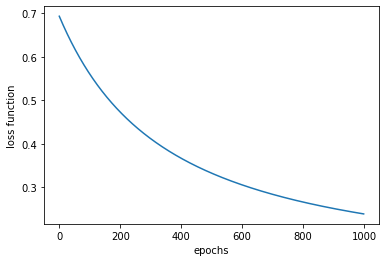

In [34]:
# cross entropy minimized
J = np.array(J).reshape(len(J))
plt.plot(range(len(J)),J)
plt.xlabel("epochs")
plt.ylabel("loss function")
plt.show()

Testing and Validation

In [35]:
def predict(x, freq, theta):
    y_pred = sigmoid((x @ theta))
    return  y_pred > 0.5

def test_accuracy(x, y, freq, theta):
    y_hat = predict(x,freq,theta)
        
    m = len(y_hat)
    y_hat = y_hat.reshape(m)
    y = y.reshape(m)
    
    test = list((y_hat == y))
    j = test.count(True)
    accuracy = j/m
    return y_hat ,accuracy*100

y_hat, accuracy = test_accuracy(X_test, y_test, freq, theta)
print("Accuracy:{}%".format(accuracy))

Accuracy:99.4%


In [36]:
pos,neg = features_extraction("Today is a beautiful day :)",freq)
print(predict([[pos,neg,1]],freq,theta))

[[ True]]


Confusion Matrix

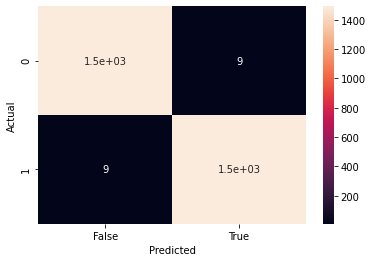

In [37]:
data = {'y_Actual':    y_test.reshape(len(y_hat)),'y_Predicted': y_hat}
df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])

confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
plt.show()